# Creating a dataset from NEXRAD LVL II reflectivity data

### ########################## THIS FIRST SECTION IS RECOMMENDED TO DO IN PARALLEL

Downloading the data and converting it to PNG files takes a lot of time, so the best approach is to do in a cluster. The downloading part I didn't do it, but for the conversion to image files in cluster mode go to repository/examples/cluster and read the README file. Otherwise, follow the next code snippets.  

# Download the data

In [ ]:
import nexradaws
from datetime import datetime
import os

You can find more information and the list of available radars, as well as an alternative to download the data here: https://www.ncdc.noaa.gov/nexradinv/

Parameters to download the data from AWS:

In [ ]:
save_dir = "../data/auxiliary_dataset_folder/" # where files are going to be downloaded
from_to_year = [2020,2020]                     # which range of years to download
from_to_month = [4,4]                          # which range of month to download
from_to_day = [4,13]                           # which range of days to download
radar = 'KFWS'                                 # from which radar 

In [ ]:
try:
    os.mkdir(save_dir)
except:
    pass
conn = nexradaws.NexradAwsInterface()
for year in range(from_to_year[0],from_to_year[1]+1):
    try:
        start = datetime(year, from_to_month[0], from_to_day[0], 0, 0)
        end = datetime(year, from_to_month[1], from_to_day[1], 0, 0)
        scans=conn.get_avail_scans_in_range(start, end, radar)
        localfiles = conn.download(scans, save_dir);
        print('##############',year, len(scans))
    except:
        print('##############',year, 'failed')
    
# delete files finishing in _MDM
for filename in os.listdir(save_dir):
    if '_MDM' in filename:
        os.remove(save_dir+'/'+filename) 

# Convert ar2v (NexRad files) to PNG (image file)

In [ ]:
import numpy as np
import os
import imageio
import pyart

In [ ]:
def nexrad2cartesian(radar, size):
    '''
    Parameters:
        radar: from pyart.io.read_nexrad_archive() 
        size: tuple with desire image dimensions Height x Width
    Returns:
        numpy array with the reflectivity data in cartesian coordinates
        '''
##################### GRIDING CONFIGURATION ##############################################
# http://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.map.grid_from_radars.html
    grids = pyart.map.grid_from_radars(                             #  convert to cartesian
        radar, 
        grid_shape = (1, size[0], size[1]),                          # define shape of frames (first dim is Z)
        grid_limits = ((radar.altitude['data'][0], 20000.0),         # z
                       (-150000, 150000),                            # y
                       (-150000, 150000)),                           # x
        fields=['reflectivity'],                                     # which data
        gridding_algo= 'map_gates_to_grid',                          # gridding algorithm
        weighting_function='BARNES2')                                # interpolation fx
    img_mtx = grids.fields['reflectivity']['data'][0,:,:]            # grab the reflectivity data (2D image)
    img_mtx = np.clip(img_mtx,0,70)                                  # truncate the dbz to lower and upper bounds to produce same colored images when normalizing 
    img_mtx = np.ma.filled(img_mtx, fill_value=0)                    # complate missing values with 0dBZ
    img_mtx = np.rint(img_mtx/70*255)                                # re-scale to 0-255
    img_mtx = img_mtx.astype('uint8')                                # use uint8 to be efficient
##########################################################################################
    return img_mtx

In [ ]:
def nexrad2png(i_path, i_fmt='ar2v', o_fmt='png', size=(64,64)):
    
    # create the output directory
    o_path = i_path + 'PNG/'
    try:
        print("creating dir:",o_path)
        os.mkdir(o_path)
    except:
        pass             
    # iterate over the ar2v files: convert to cartesian and saved them as images
    for file in sorted(os.listdir(i_path)):  
        outfile = o_path + file + '.' + o_fmt
        try:
            radar = pyart.io.read_nexrad_archive(i_path+'/'+file) # open the ar2v file
        except Exception as e:
            print(outfile," failed")
            print(e)
            continue
            
        imageio.imwrite(outfile, nexrad2cartesian(radar, size))         # save as image          

In [ ]:
nexrad2png(save_dir)

### ################################## FINISH PARALLEL PART

## Split images in events of continuous data

As radars might fail, there might be missing data. So, here I make sure to group in different folders the files that are continuous.

In [47]:
from shutil import move, rmtree
import os
import datetime
from PIL import Image

In [44]:
def getTimeDiff(file, file_prev):
    '''
    given to file names, returns the time apart in minutes
    '''    
    n = os.path.basename(file) # get filename without path
    if len(n) == 27:
        n = n[4:-8]    
    elif len(n) == 23:
        n = n[4:-4]               # remove non-date info

    n1 = os.path.basename(file_prev)                                   # get filename without path
    if len(n1) == 27:
        n1 = n1[4:-8]    
    elif len(n1) == 23:
        n1 = n1[4:-4]  

    date_time_obj1 = datetime.datetime.strptime(n1, '%Y%m%d_%H%M%S')
    date_time_obj  = datetime.datetime.strptime(n,  '%Y%m%d_%H%M%S')
    delta = date_time_obj - date_time_obj1                          # delta in seconds
    seconds = datetime.timedelta(delta.days, delta.seconds).total_seconds() #correction for negative numbers

    return seconds/60

def isRainy(mtx, value=False):
    ''' Returns True if a frame is considered to have rain content, to filter the non-rainy events out.
    NOT IMPLEMENTED as events containing non-rainy events and developing storms are also desidered
    '''
    return True

    
def splitImagesInEvents(i_path, minutes):
    '''
    Re-order PNGs into files, grouping them by chuncks of continuous times.
    Parameters:
        i_path: directory with PNG files
        minutes: tolerance in minutes to consider to frames continuous
    
    Returns:
        None
    '''
    i_event = 0                                         
    so_path = i_path + 'event_' + str(i_event) + '/'
    os.mkdir(so_path)
    file_prev = None
    
    for file in sorted(os.listdir(i_path)):    
        if not file.endswith('png'): continue
        img_mtx = np.array(Image.open(i_path+file))
        if isRainy(img_mtx): 
        # implement isRainy() if want to discard non-rainy frames, which would cause a gap in time
            if isConsecutiveFrame(file_prev, file, minutes):                   
                move(i_path+file, so_path+file)                       
            else:  # if not consecutive, frames are divided in folder of continues frames
                i_event += 1
                so_path = i_path + 'event_' + str(i_event) + '/'
                os.mkdir(so_path)
                move(i_path+file, so_path+file)
        file_prev = file

def isConsecutiveFrame(file_prev, file, minutes):
    '''
    given to file names, returns True if they are less than 'minutes' apart.   
    # filename example 1: KCYS20190301_023051_V06.png
    # filename example 2: KCYS20190301_023051.png
    '''    
    if file_prev==None:
        return True
    else:
        return getTimeDiff(file, file_prev) < minutes  
    

In [46]:
png_dir = "../data/auxiliary_dataset_folder/PNG/"
splitImagesInEvents(png_dir, minutes=7)

### Delete folders with less than N frames

Just to avoid having multiple folders with really few files

In [49]:
def getSizeDir(path):
    return len([name for name in os.listdir(path)])
    #return len([name for name in os.listdir(path) if os.path.isfile(path+name)])

def delFolderWithLess(dir1, N):
    for subdir, dirs, files in os.walk(dir1):
        if not ('event' in subdir): continue
        l = getSizeDir(subdir)
        print(subdir, 'has', l, 'files')
        if l < N:                                     # remove all dirs that have less than 20 frames
            rmtree(subdir)

In [50]:
delFolderWithLess(png_dir, N=16)

../data/auxiliary_dataset_folder/PNG/event_0 has 227 files
../data/auxiliary_dataset_folder/PNG/event_1 has 1 files


## Create numpy files with the events

In [54]:
def events2dataset(in_dir, seq_length, H=64,W=64):
    '''
    Parameters:
        in_dir: directory with event folders
        dataset_name: name for the output npy file
        seq_length: length of each event (sample)
        H,W: height and width of the images
    Returns:
        data: numpy file with multiple events 
        data_names: numpy file names of each event 
    '''
    data = np.zeros([1,seq_length,H,W], dtype='uint8')
    data_names = np.zeros([1,seq_length], dtype=object)

    for subdir, dirs, files in os.walk(in_dir):
        if not ('event' in subdir): continue   
        if getSizeDir(subdir) < seq_length: continue # ignore events with less than N frames
        data_aux = []
        data_name_aux = []
        files.sort()
        indexes = group_indexes(len(files),seq_length)
        for i in indexes:                         # discard surplus frames
            for f in files[i:i+seq_length]:   # iterate files and create dataset matrix
                img = Image.open(subdir+'/'+f)
                data_aux.append(np.array(img, dtype='uint8'))        
                data_name_aux.append(f)    
            #print(np.expand_dims(np.array(data_aux),axis=0).shape)
            data = np.append(data,np.expand_dims(np.array(data_aux),axis=0),0)
            data_names = np.append(data_names,np.expand_dims(np.array(data_name_aux),axis=0),0)
            data_aux = []
            data_name_aux = [] 
    data  = np.delete(data,0,0)
    data_names  = np.delete(data_names,0,0)
    return data, data_names
            
def group_indexes(total_length,seq_length):
    '''
    returns a list of initial indexes for using all "total_length" events in groups of "seq_length"
    '''
    # training frames can be those used as prediction for other sequence
    groups_length = seq_length/2
    index = []
    i=0
    while i+seq_length < total_length:# i in range(int(total_length/groups_length)):
        index.append(i)
        i = i+groups_length
    #if there are N=10 frames unused, overlap so they are included
    if total_length-i+groups_length-seq_length >= 10:
        index.append(total_length-seq_length)
    return [int(j) for j in index]

In [56]:
dataset = "dataset"
data, data_names = events2dataset(png_dir, seq_length=32)
np.save(png_dir + dataset, data)
np.save(png_dir + dataset + '_names', data_names)
s,f,h,w = data.shape
print("Dataset has",s,'events of',f,'frames')

Dataset has 13 events of 32 frames


# Auxiliary dataset operations

Merge, balance, training/validation splits

### Filter non-rainy events

In [83]:
import context
from mlnowcasting.utils.utils import is_rainy_event
import os

def filter_non_rainy(dataset_path, th_dbz=30, th_frame=1):
    '''
    Remove all non-rainy events from the dataset
    Parameters:
        dataset_path: path to load the dataset
        th_dbz: reflectivity threshold to consider rainy a frame of the event
        th_frame: number of frames threshold to consider rainy an event
    Returns:
        data: filtered dataset
        <names>: filtered names (only if the path to the names files was found)
    '''
    data = np.load(dataset_path)
    idx = []
    for i in range(len(data)):
        rainy = is_rainy_event(data[i], th=th_dbz/70*255, n_frame_th=th_frame)
        if not rainy:
            idx = np.append(idx,i)
    data = np.delete(data,idx, axis=0)
    
    dataset_names_path = dataset_path[:-4]+'_names'+dataset_path[-4:]
    try:
        names = np.load(dataset_names_path, allow_pickle=True)
        names = np.delete(names,idx, axis=0)
        return data,names
    except:
        print("No name file found:",dataset_names_path)
        return data

In [89]:
dataset_path = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset (and dataset_names of exists)
new_dataset = "dataset_filtered" # name of the new dataset

data, data_names = filter_non_rainy(dataset_path, th_dbz=30, th_frame=1)

output_dir = os.path.dirname(os.path.abspath(dataset_path))
np.save(output_dir + '/' + new_dataset, data)
np.save(output_dir + '/' + new_dataset + '_names', data_names)
s,f,h,w = data.shape
print("Dataset has",s,'events of',f,'frames')

Dataset has 0 events of 32 frames


/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/s/chopin/a/grad/jcuomo/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


### Merge datasets

In [ ]:
def combine_datasets(list_of_datasets, out_path, frames, height, width):
    new_data = np.zeros([1,frames, height, width], dtype='uint8')
    for data_path in list_of_datasets:
        data = np.load(data_path)
        new_data = np.append(new_data,data,0)

    return np.delete(data,0,0)


In [ ]:
list_of_datasets = ['./datasetA.npy',
                    './datasetB.npy',
                    './datasetC.npy']

new_dataset_filename = './combined_dataset.npy'

data = combine_datasets(list_of_datasets, new_dataset_filename, frames=32, height=64, width=64)
np.save(new_dataset_filename, data)

### Reshape dataset: frame resolution
Only recommended to decrease the resolution.

In [132]:
import cv2

def reshape_frame_resolution(i_path, new_size=(64,64)):
    large_images = np.load(i_path)
    small_images = np.zeros((large_images.shape[0],large_images.shape[1],new_size[0],new_size[1]), dtype='uint8')
    for s in range(large_images.shape[0]):
        for i in range(large_images.shape[1]):
            # cv2.INTER_AREA is used just because is the recommended in the cv2.resize fx for donwsampling
            small_images[s,i] = cv2.resize(large_images[s,i], dsize=new_size, interpolation=cv2.INTER_AREA)
    return small_images

In [140]:
dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
new_dataset = "dataset_reshaped_resolution" 

data = reshape_frame_resolution(dataset_path, new_size=(32,32))

output_dir = os.path.dirname(os.path.abspath(dataset_path))
np.save(output_dir + '/' + new_dataset, data)
s,f,h,w = data.shape
print("Dataset has",s,'events of',str(h)+'x'+str(w),'frames')

Dataset has 13 events of 128x128 frames


### Reshape dataset: frames per event
Only to decrease the number of frames. 
It uses a sliding windows of 1.

In [138]:
def reshape_indexes(old_length, new_length):
    'return N indexes from original sequence to create N shorter sequences'
    index = []
    i=0
    while i+new_length <= old_length:# i in range(int(total_length/groups_length)):
        index.append(i)
        i = i+1
    return [int(j) for j in index]

def reshape_frame_dim(file, new_length):
    '''
    Reshapes a dataset e.g. shape(13,32,64,64) to e.g. shape(117,24,64,64), 
    where the new one has 117 produced by a sliding window of size 1, (32-24+1)*13
    '''
    data = np.load(file)
    s, old_length, H, W = data.shape
    if old_length < new_length:
        print("Cannot increase the number of frames, only decrease it")
        return
    new_data = np.zeros([1,new_length,H,W], dtype='uint8')
    for index in reshape_indexes(old_length, new_length):
        new_data = np.append(new_data,data[:,index:index+new_length],0)
    return np.delete(new_data,0,0)

In [139]:
dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
new_dataset = "dataset_reshaped_length" 

data = reshape_frame_dim(dataset_path, new_length=24)

output_dir = os.path.dirname(os.path.abspath(dataset_path))
np.save(output_dir + '/' + new_dataset, data)
s,f,h,w = data.shape
print("Dataset has",s,'events of',f,'frames')

Dataset has 117 events of 24 frames


### Balanced and shuffled dataset (by downsampling non-rainy days)

In [118]:
def resampleDataset(file, th_dbz, th_frames):
    data = np.load(file)
    rainy_info = np.zeros((data.shape[0],3), dtype='uint8') # boolean_is_rainy, score_of_how_rainy, index
    for i in range(len(data)):
        is_rainy, (score, n_rainy_frames) =  is_rainy_event(data[i], 
                                                          th_dbz/70*255, 
                                                          th_frames, 
                                                          return_score=True)
        rainy_info[i] = [is_rainy, n_rainy_frames, i]
    
    rainy_seqs     = np.count_nonzero(rainy_info==1, axis=0)[0]
    non_rainy_seqs = np.count_nonzero(rainy_info==0, axis=0)[0]
    idx = []
    # if there are more non-rainy days than rainy days, crop non-rainy to match rainy
    if non_rainy_seqs > rainy_seqs:
        rainy_info = rainy_info[rainy_info[:,1].argsort()] #ordered by rainy score
        j = 0
        for i in range(len(rainy_info)):
            if j == rainy_seqs:
                break
            if rainy_info[i,0] == 0:
                rainy_info[i,0] = 1
                j += 1
        idx = rainy_info[rainy_info[:,0]==1,2]
        resampled_data = data[idx]
    # if not, just return the original dataset
    else:
        resampled_data = data
    print("Rainy events:", rainy_seqs, ", Non-Rainy events:", non_rainy_seqs)
    return resampled_data

In [127]:
dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
new_dataset = "dataset_balanced" 

data = resampleDataset(dataset_path, th_dbz=30, th_frames=1)

output_dir = os.path.dirname(os.path.abspath(dataset_path))
np.save(output_dir + '/' + new_dataset, data)
s,f,h,w = data.shape
print("Dataset has",s,'events of',f,'frames')

Rainy events: 0 , Non-Rainy events: 13
Dataset has 0 events of 32 frames


### Train and validation splitting

Highly discourage, as events really similar can appear in both training and validation.
Best approach: use a completely different time frame for validation.

In [128]:
from sklearn.model_selection import train_test_split

dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
new_dataset = "dataset_balanced" 
test_size = 0.2

train, val = train_test_split(np.load(dataset_path), test_size=test_size, random_state=123, shuffle=True)
print('Train dataset has', train.shape[0],'events')
print('Validation dataset has', val.shape[0],'events')
output_dir = os.path.dirname(os.path.abspath(dataset_path))
np.save(output_dir + '/' + new_dataset + '_train', train)
np.save(output_dir + '/' + new_dataset + '_validation', val)

/usr/local/anaconda-2019.07/lib/python3.7/site-packages/nose/config.py:178: DeprecationWarning: invalid escape sequence \.
  """


Train dataset has 10 events
Validation dataset has 3 events


# Analyzing dataset

### Visualizing

In [184]:
import context
from mlnowcasting.utils.plot_utils import plot_pred

def plot_dataset(dataset_path, N_events=None, N_frames=10, title_1st=None, scan_time=5):
    
    data = np.load(dataset_path)/255*70
    length = data.shape[0]
    if N_events is None:
        N_events = length
    plt.figure(figsize=(20,length*3));
    masked_th = 20 #dbz
    for i,event in enumerate(data):
        if i==N_events:
            break
        is_last_iteration = (i==N_events-1)
        layer = np.ma.masked_where(event < masked_th, event)
        plot_pred(layer, 
                  N_frames=N_frames, 
                  label=i, 
                  scan_time=scan_time, 
                  title_1st=title_1st[i],
                  plot_colorbar=is_last_iteration, 
                  bottom_label=is_last_iteration);

<Figure size 1440x2808 with 0 Axes>

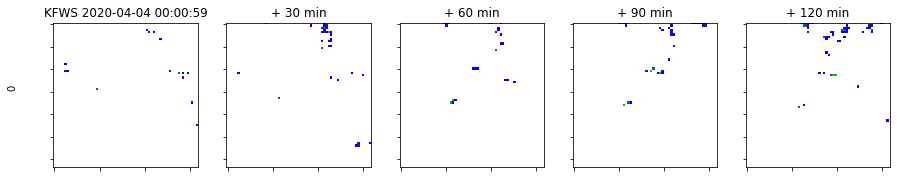

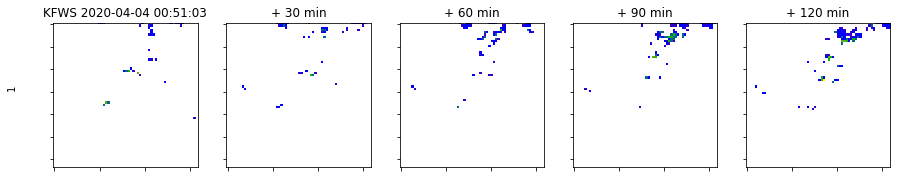

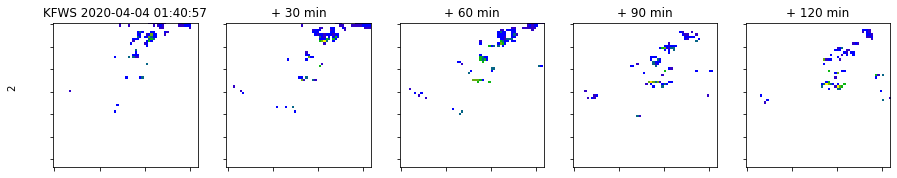

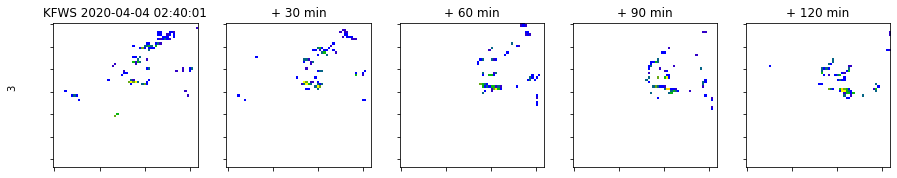

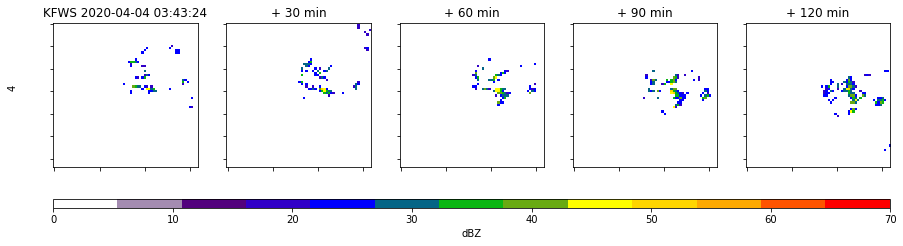

In [185]:
dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
dataset_names_path     = "../data/auxiliary_dataset_folder/PNG/dataset_names.npy" # path to load dataset
names_1st = np.load(dataset_names_path, allow_pickle=True)[:,0]
plot_dataset(dataset_path, N_events=5, N_frames=5, title_1st=names_1st, scan_time=5);

### Reflectivity content

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(dataset_path, N_plots=5, titles=None):
    data = np.load(dataset_path)
    length = data.shape[1]
    skip_frames = int(length/N_plots)
    plt.figure(figsize=(15,3))
    first=True
    for i in range(N_plots):
        plt.subplot(1,N_plots,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.xlabel('Reflectivity [dBZ]')
        if first:
            plt.ylabel('% per frame')
            first=False
        else:
            plt.yticks([])
        x, bins, p = plt.hist(data[0,i*skip_frames].flatten()/255*70,70, density=True);
        plt.ylim(0,1)
        plt.xlim(0,70)
        plt.tight_layout()

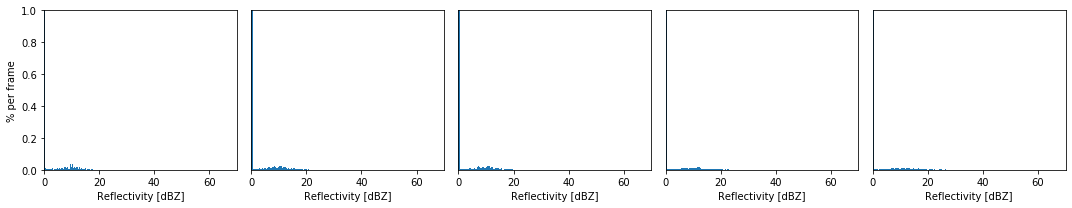

In [158]:
dataset_path     = "../data/auxiliary_dataset_folder/PNG/dataset.npy" # path to load dataset
titles=['- 1 hr 20 min', '- 40 min', '+ 0 min', '+ 1 hr 20 min', '+ 2 hr']
plot_histogram(dataset_path)